# CSML1010 Project Working Copy
# Sentiment Analysis with the Sentiment140 dataset
## Pete Gray - YorkU #217653247

---------------------------------------------------------

## Introduction

In this project we explore and learn about natural language processing and the lifecycle of machine learning projects. Sentiment analysis will be performed using the Sentiment140 dataset[1]. We will explicity execute data cleaning, data exploration, feature engineering, feature selection, modeling, model selection, and [OTHER STUFF?] The code is mostly assembled from bits and pieces of the coding exercises that are part of the course CSML1010, Fall 2019, at York University, Toronto.

[1] http://help.sentiment140.com/for-students

###### TABLE OF CONTENTS

1. Load data and libraries
2. Data Cleaning
3. Data Exploration
4. Feature Engineering
5. Feature Selection

# Import libraries

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, linewidth=80)
import warnings
warnings.filterwarnings("ignore")
import model_evaluation_utils as meu


# Adjust pandas display

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

# Import matplotlib and seaborn and adjust defaults

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## Read data from local filesystem and csv source 

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")

Check data with quick visual inspection

In [5]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Give dataframe columns

In [6]:
df.columns = ['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [7]:
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

### Now it has columns, this seems better.

### Check for nulls in the Text column

In [8]:
df = df[df["Text"].notnull()]
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

# Set temporary dataset size, for quicker processing

In [9]:
dev_data_size = 1000

In [10]:
start_row = int(800000-(dev_data_size/2))-1
finish_row = int(800000+(dev_data_size/2))-1
df_sm = df[start_row:finish_row]
df_sm.count()

sentiment    1000
ID           1000
Time         1000
none         1000
username     1000
Text         1000
dtype: int64

In [11]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [12]:
raw_text = np.array(df_sm['Text'])
sentiments = np.array(df_sm['sentiment'])
raw_text[5:15]

array(['@teamDdemiLovato what u hahahahaing me for? what did i do ',
       '@jeepersmedia hi mike did you hear the farrah fawcett died ',
       'Farrah Fawcett died   Cancer sucks', 'I am heartbroken about Farrah. ',
       "being annoyed with ?'s that i dont like 15 more days until i go back to arizona i just might kill myself before i even leave!!! ",
       "On the streetcar to work.  Why isn't today Friday?? ",
       'Farrah Fawecett passed away  the former Charlies Angel WILL be missed. I send my prayers to the family   ;(',
       'Sooo close to finshing this modle and why is it rendering always frows a fit and stops working ',
       'She passed less than a 1/2 hr after the show was over  Barbara Walters was classy as always speaking about Farrah.',
       '@jimmuncie I just read that! '], dtype=object)

In [13]:
sentiments[4995:5005]

array([], dtype=int64)

-----------------------

# =======================
# Data Cleaning
# =======================

-----------------------

## Cleaning function

In [14]:
import re
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    
    # As a sanity check - s = s.replace(r'W', "Q")
    
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    
    
    # The numbers in the data came to light during feature engineering. 
    # I will try different things here.
    
    # A processor-efficient approach, as suggested at:
    # https://stackoverflow.com/questions/30315035/strip-numbers-from-string-in-python
    # s = s.translate(None, '0123456789')
    # Well, that totally didn't work.
    
    # From the same link, a more conventional, but less efficient approach:
    
    s = re.sub(r'\d+', '', s)
    
    
    
    
    
    return str(s)

## Create new column in dataframe

In [15]:
df_sm["text_clean"] = ''

# Iterate and clean

In [16]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_clean"] = clean(row.Text)

processed: 800000


### Check results

In [17]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean
799499,0,2329004031,Thu Jun 25 10:14:17 PDT 2009,NO_QUERY,magazinemama,@kristacolvin I have that cd in my car right now. Now song in my head,@kristacolvin I have that cd in my car right now. Now song in my head
799500,0,2329004221,Thu Jun 25 10:14:18 PDT 2009,NO_QUERY,troythewatson,Poor Farrah RIP Beautiful,Poor Farrah RIP Beautiful
799501,0,2329004394,Thu Jun 25 10:14:18 PDT 2009,NO_QUERY,maggiejoella,Annie is going to Korea tomorrow.. I wanna travel so badly. I wish I can go with her!!!! Ahahah.. Ahhhhhhhhhhhhh.........,Annie is going to Korea tomorrow.. I wanna travel so badly. I wish I can go with her!!!! Ahahah.. Ahhhhhhhhhhhhh.........
799502,0,2329004449,Thu Jun 25 10:14:19 PDT 2009,NO_QUERY,chloexoxoxox,why does home and away have to be so upsetting,why does home and away have to be so upsetting
799503,0,2329004473,Thu Jun 25 10:14:19 PDT 2009,NO_QUERY,TheLadyKristin,@ShelbyCasanova don't brag Tizzy is my future wife. Like hardcore. I want to date her!,@ShelbyCasanova don't brag Tizzy is my future wife. Like hardcore. I want to date her!


## Additional pre-processing: tokenization, removing extra whitespaces, lower casing and more advanced operations like spelling corrections, grammatical error corrections, removing repeated characters.

In [18]:
import nltk
wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define normalization function

In [19]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [20]:
normalize_corpus = np.vectorize(normalize_document)

In [21]:
df_sm["text_normalized"] = ''

In [22]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_normalized"] = normalize_corpus(row.text_clean)

processed: 800000


### check results

In [23]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized
799499,0,2329004031,Thu Jun 25 10:14:17 PDT 2009,NO_QUERY,magazinemama,@kristacolvin I have that cd in my car right now. Now song in my head,@kristacolvin I have that cd in my car right now. Now song in my head,kristacolvin cd car right song head
799500,0,2329004221,Thu Jun 25 10:14:18 PDT 2009,NO_QUERY,troythewatson,Poor Farrah RIP Beautiful,Poor Farrah RIP Beautiful,poor farrah rip beautiful
799501,0,2329004394,Thu Jun 25 10:14:18 PDT 2009,NO_QUERY,maggiejoella,Annie is going to Korea tomorrow.. I wanna travel so badly. I wish I can go with her!!!! Ahahah.. Ahhhhhhhhhhhhh.........,Annie is going to Korea tomorrow.. I wanna travel so badly. I wish I can go with her!!!! Ahahah.. Ahhhhhhhhhhhhh.........,annie going korea tomorrow wanna travel badly . wish go !!!! ahahah .. ahhhhhhhhhhhhh .........
799502,0,2329004449,Thu Jun 25 10:14:19 PDT 2009,NO_QUERY,chloexoxoxox,why does home and away have to be so upsetting,why does home and away have to be so upsetting,home away upsetting
799503,0,2329004473,Thu Jun 25 10:14:19 PDT 2009,NO_QUERY,TheLadyKristin,@ShelbyCasanova don't brag Tizzy is my future wife. Like hardcore. I want to date her!,@ShelbyCasanova don't brag Tizzy is my future wife. Like hardcore. I want to date her!,shelbycasanova dont brag tizzy future wife . like hardcore . want date !
...,...,...,...,...,...,...,...,...
800494,4,1467917110,Mon Apr 06 22:48:07 PDT 2009,NO_QUERY,brypie,@apleaforaaron i could really eat some cheese i have a hankering for some austrian smoked cheese. YUM!,@apleaforaaron i could really eat some cheese i have a hankering for some austrian smoked cheese. YUM!,apleaforaaron could really eat cheese hankering austrian smoked cheese yum !
800495,4,1467917121,Mon Apr 06 22:48:07 PDT 2009,NO_QUERY,aaalison,@ddlovato I am so FUCKING jealous of you girl. Have fun though xxx,@ddlovato I am so FUCKING jealous of you girl. Have fun though xxx,ddlovato fucking jealous girl fun though xxx
800496,4,1467917197,Mon Apr 06 22:48:08 PDT 2009,NO_QUERY,Stereo_Skyline,@ThaStevieG my bunnys name was Lucy you can go ahead and guess who she was named after lmao,@ThaStevieG my bunnys name was Lucy you can go ahead and guess who she was named after lmao,thastevieg bunnys name lucy go ahead guess named lmao
800497,4,1467917277,Mon Apr 06 22:48:12 PDT 2009,NO_QUERY,inworship,@pixelpipe any updates for iPhone OS 3.0 yet? I miss you guys,@pixelpipe any updates for iPhone OS . yet? I miss you guys,pixelpipe updates iphone os yet ? miss guys


In [24]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [25]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["text_normalized"] and len(str(row["text_normalized"])) < 1000000):
        doc = nlp(str(row["text_normalized"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df_sm.at[i, "text_lemma"] = " ".join(lemmas)                
        df_sm.at[i, "text_nouns"] = " ".join(nouns)
        df_sm.at[i, "text_adjectives"] = " ".join(adjectives)
        df_sm.at[i, "text_verbs"] = " ".join(verbs)
        df_sm.at[i, "text_nav"] = " ".join(nouns+adjectives+verbs)
        df_sm.at[i, "no_tokens"] = len(lemmas)

800000


In [26]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
799499,0,2329004031,Thu Jun 25 10:14:17 PDT 2009,NO_QUERY,magazinemama,@kristacolvin I have that cd in my car right now. Now song in my head,@kristacolvin I have that cd in my car right now. Now song in my head,kristacolvin cd car right song head,kristacolvin cd car right song head,kristacolvin cd car song head,right,,kristacolvin cd car song head right,6.00
799500,0,2329004221,Thu Jun 25 10:14:18 PDT 2009,NO_QUERY,troythewatson,Poor Farrah RIP Beautiful,Poor Farrah RIP Beautiful,poor farrah rip beautiful,poor farrah rip beautiful,farrah,poor beautiful,rip,farrah poor beautiful rip,4.00
799501,0,2329004394,Thu Jun 25 10:14:18 PDT 2009,NO_QUERY,maggiejoella,Annie is going to Korea tomorrow.. I wanna travel so badly. I wish I can go with her!!!! Ahahah.. Ahhhhhhhhhhhhh.........,Annie is going to Korea tomorrow.. I wanna travel so badly. I wish I can go with her!!!! Ahahah.. Ahhhhhhhhhhhhh.........,annie going korea tomorrow wanna travel badly . wish go !!!! ahahah .. ahhhhhhhhhhhhh .........,annie go korea tomorrow wanna travel badly . wish go ! ! ! ! ahahah .. ahhhhhhhhhhhhh .........,annie korea tomorrow wanna wish ahhhhhhhhhhhhh,,go travel go ahahah,annie korea tomorrow wanna wish ahhhhhhhhhhhhh go travel go ahahah,18.00
799502,0,2329004449,Thu Jun 25 10:14:19 PDT 2009,NO_QUERY,chloexoxoxox,why does home and away have to be so upsetting,why does home and away have to be so upsetting,home away upsetting,home away upsetting,,upsetting,,upsetting,3.00
799503,0,2329004473,Thu Jun 25 10:14:19 PDT 2009,NO_QUERY,TheLadyKristin,@ShelbyCasanova don't brag Tizzy is my future wife. Like hardcore. I want to date her!,@ShelbyCasanova don't brag Tizzy is my future wife. Like hardcore. I want to date her!,shelbycasanova dont brag tizzy future wife . like hardcore . want date !,shelbycasanova do not brag tizzy future wife . like hardcore . want date !,shelbycasanova wife hardcore date,tizzy future,brag want,shelbycasanova wife hardcore date tizzy future brag want,14.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800494,4,1467917110,Mon Apr 06 22:48:07 PDT 2009,NO_QUERY,brypie,@apleaforaaron i could really eat some cheese i have a hankering for some austrian smoked cheese. YUM!,@apleaforaaron i could really eat some cheese i have a hankering for some austrian smoked cheese. YUM!,apleaforaaron could really eat cheese hankering austrian smoked cheese yum !,apleaforaaron could really eat cheese hanker austrian smoke cheese yum !,apleaforaaron cheese austrian cheese yum,,could eat hanker smoke,apleaforaaron cheese austrian cheese yum could eat hanker smoke,11.00
800495,4,1467917121,Mon Apr 06 22:48:07 PDT 2009,NO_QUERY,aaalison,@ddlovato I am so FUCKING jealous of you girl. Have fun though xxx,@ddlovato I am so FUCKING jealous of you girl. Have fun though xxx,ddlovato fucking jealous girl fun though xxx,ddlovato fuck jealous girl fun though xxx,ddlovato girl fun xxx,jealous,fuck,ddlovato girl fun xxx jealous fuck,7.00
800496,4,1467917197,Mon Apr 06 22:48:08 PDT 2009,NO_QUERY,Stereo_Skyline,@ThaStevieG my bunnys name was Lucy you can go ahead and guess who she was named after lmao,@ThaStevieG my bunnys name was Lucy you can go ahead and guess who she was named after lmao,thastevieg bunnys name lucy go ahead guess named lmao,thastevieg bunnys name lucy go ahead guess name lmao,thastevieg bunnys name lucy lmao,,go guess name,thastevieg bunnys name lucy lmao go guess name,9.00
800497,4,1467917277,Mon Apr 06 22:48:12 PDT 2009,NO_QUERY,inworship,@pixelpipe any updates for iPhone OS 3.0 yet? I miss you guys,@pixelpipe any updates for iPhone OS . yet? I miss you guys,pixelpipe updates iphone os yet ? miss guys,pixelpipe update iphone os yet ? miss guy,pixelpipe iphone os miss guy,,update,pixelpipe iphone os miss guy update,8.00


In [27]:
# Save in case we need it later:


df_sm = df_sm[df_sm["text_nav"].notnull()]
df_sm.count()

# shuffle the dataset for later.
# Note this isn't necessary (the dataset is shuffled again before used), 
# but is good practice.
# df = df.sample(frac=1)

sentiment          1000
ID                 1000
Time               1000
none               1000
username           1000
Text               1000
text_clean         1000
text_normalized    1000
text_lemma         1000
text_nouns         1000
text_adjectives    1000
text_verbs         1000
text_nav           1000
no_tokens          1000
dtype: int64

----------------------------------------

# Saving Cleaned Data to the Filesystem

### So I can run without re-cleaning, or move a chunk to the Cloud for experiments.

In [28]:
# save cleaned data

# df_sm.to_csv('cleaned01.csv', encoding='utf-8', index=False)

# Loading Cleaned Data from the Filesystem

### Saved in various sizes, load as appropriate

In [29]:
# df_sm = pd.read_csv("s140_cln_100k.csv", encoding="utf-8")

## s140_cln_100k.csv

----------------------------

# =========================
# Data Exploration
# =========================

----------------------------

### Is dataset balanced?

We know that the original dataset is split right down the middle, with 800,000 positive documents and 799,999 negative. Let's check that:

In [30]:
df['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

Excellent. Now, let's check that our hackishly sampled little subset is also balanced:

In [31]:
df_sm['sentiment'].value_counts()

4    500
0    500
Name: sentiment, dtype: int64

Excellent! Perfectly balanced.

### Show data types in each column

In [32]:
df_sm.dtypes

sentiment          int64  
ID                 int64  
Time               object 
none               object 
username           object 
Text               object 
text_clean         object 
text_normalized    object 
text_lemma         object 
text_nouns         object 
text_adjectives    object 
text_verbs         object 
text_nav           object 
no_tokens          float64
dtype: object

### Summary of numerical features

Not the most useful thing, but helpful as a quick sanity check.

In [33]:
df_sm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,1000.00,2.00,2.00,0.00,0.00,2.00,4.00,4.00
ID,1000.00,1898487692.66,430839017.05,1467822272.00,1467863196.75,1898460655.50,2329114397.50,2329205794.00
no_tokens,1000.00,9.44,5.58,1.00,5.00,8.50,13.00,28.00


### Exploring text at different levels of cleaning

In [34]:
df_sm[['text_clean','text_normalized','text_lemma','text_nav']].sample(10)

,text_clean,text_normalized,text_lemma,text_nav
799901,@JapanNewbie woohoo I'm all for slack time.. I'm goin crazy at work,japannewbie woohoo im slack time .. ' goin crazy work,japannewbie woohoo -PRON- be slack time .. ' go crazy work,japannewbie woohoo slack time work crazy be go
800490,aww dont make me blush!,aww dont make blush,aww do not make blush,blush make
799502,why does home and away have to be so upsetting,home away upsetting,home away upsetting,upsetting
799516,i just got a new car..... beginning to think i should of just kept my old one???? man im lost for words,got new car ... beginning think kept old one ???? man im lost words,get new car ... begin think keep old one ? ? ? ? man -PRON- be lose word,car think word new old get begin keep be lose
799698,"@HitmanPR RIP Farrah, we will all miss u tears are flowing around the world at our loss of such a true Angel, your wings are now free","hitmanpr rip farrah miss u tears flowing around world loss true angel , wings free","hitmanpr rip farrah miss u tear flow around world loss true angel , wing free",hitmanpr rip farrah miss tear world loss angel wing true free flow
799749,awwww. i just found out farrah fawcett died,awwww found farrah fawcett died,awwww find farrah fawcett die,awwww farrah fawcett find die
799909,No farrah on my list,farrah list,farrah list,farrah list
799538,"aw RIP Farrah Fawcett. what a beautiful woman. Praying for her family, especially her dad","aw rip farrah fawcett beautiful woman praying family , especially dad","aw rip farrah fawcett beautiful woman pray family , especially dad",farrah fawcett woman family dad beautiful rip pray
800162,@KatiePorrello thank you Katie! heading to the club as we speak! you have yourself a stellar night as well... take it easy homey!!,katieporrello thank katie heading club speak ! stellar night well ... take easy homey !!,katieporrello thank katie head club speak ! stellar night well ... take easy homey ! !,katieporrello katie club night homey stellar easy thank head speak take
799677,"RIP Farrah Fawcett. She was such a bright shining star, and my personal hair icon. She will be missed",rip farrah fawcett bright shining star personal hair icon . missed,rip farrah fawcett bright shine star personal hair icon . miss,farrah fawcett star hair icon bright personal rip shine miss


In [35]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

### Creating a List of Tokens from a List of Documents

In [36]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [37]:
tokens = df_sm.text_nav.map(my_tokenizer).sum()

In [38]:
print(tokens[:200])

['kristacolvin', 'cd', 'car', 'song', 'head', 'right', 'farrah', 'poor', 'beautiful', 'rip', 'annie', 'korea', 'tomorrow', 'wanna', 'wish', 'ahhhhhhhhhhhhh', 'go', 'travel', 'go', 'ahahah', 'upsetting', 'shelbycasanova', 'wife', 'hardcore', 'date', 'tizzy', 'future', 'brag', 'want', 'teamddemilovato', 'u', 'hahahahaing', 'jeepersmedia', 'hi', 'mike', 'farrah', 'fawcett', 'hear', 'die', 'farrah', 'fawcett', 'cancer', 'suck', 'die', 'farrah', 'heartbroken', 'day', 'arizona', 'annoy', 'like', 'go', 'may', 'kill', 'leave', 'streetcar', 'work', 'today', 'friday', 'farrah', 'fawecett', 'charlie', 'angel', 'prayer', 'family', 'former', 'pass', 'miss', 'send', 'sooo', 'modle', 'rendering', 'stop', 'fit', 'close', 'finshe', 'frow', 'work', 'hr', 'show', 'barbara', 'walters', 'classy', 'farrah', 'less', 'pass', 'speak', 'jimmuncie', 'read', 'loss', 'icon', 'farrah', 'fawcett', 'sadden', 'love', 'hurt', 'get', 'use', 'car', 'think', 'word', 'new', 'old', 'get', 'begin', 'keep', 'be', 'lose', 'sch

### Counting Frequencies with a Counter

In [39]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('farrah', 127),
 ('go', 109),
 ('fawcett', 88),
 ('good', 75),
 ('sad', 68),
 ('get', 67),
 ('day', 58),
 ('love', 58),
 ('work', 51),
 ('be', 50),
 ('miss', 48),
 ('time', 46),
 ('quot', 44),
 ('rip', 43),
 ('want', 42),
 ('know', 40),
 ('die', 37),
 ('today', 37),
 ('make', 37),
 ('thank', 36)]

In [40]:
print([t[0] for t in counter.most_common(200)]) 

['farrah', 'go', 'fawcett', 'good', 'sad', 'get', 'day', 'love', 'work', 'be', 'miss', 'time', 'quot', 'rip', 'want', 'know', 'die', 'today', 'make', 'thank', 'think', 'see', 'feel', 'night', 'tomorrow', 'pass', 'new', 'tonight', 'peace', 'say', 'rest', 'lol', 'come', 'could', 'thing', 'morning', 's', 'great', 'need', 'u', 'hear', 'angel', 'hope', 'can', 'would', 'bad', 'try', 'jonathanrknight', 'find', 'tell', 'twitter', 'last', 'watch', 'week', 'sleep', 'wish', 'take', 'happy', 'bed', 'friend', 'show', 'sorry', 'hate', 'eat', 'look', 'much', 'cancer', 'leave', 'family', 'read', 'hurt', 'lose', 'let', 'tweet', 'r', 'guy', 'glad', 'may', 'charlie', 'life', 'hour', 'hot', 'wait', 'way', 'hair', 'year', 'use', 'old', 'school', 'people', 'man', 'game', 'fun', 'news', 'first', 'god', 'well', 'help', 'have', 'talk', 'ur', 'mean', 'haha', 'home', 'song', 'head', 'right', 'suck', 'amazing', 'w', 'nice', 'house', 'enough', 'n', 'battle', 'many', 'call', 'big', 'do', 'seem', 'goodnight', 'updat

### Remove stopwords from list of tokens

In [41]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

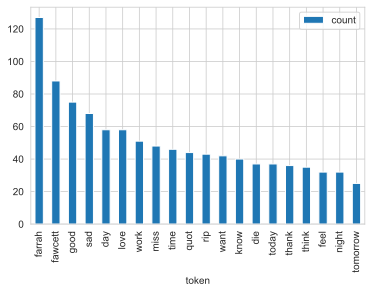

In [42]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

## Word clouds

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

In [44]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### The Word Cloud!!

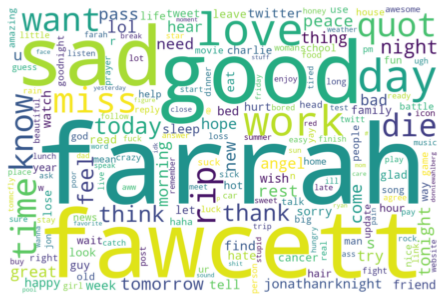

In [45]:
wordcloud(counter)

### Positive words, negative words

Let's do some charts and clouds for exclusively positive or negative samples.

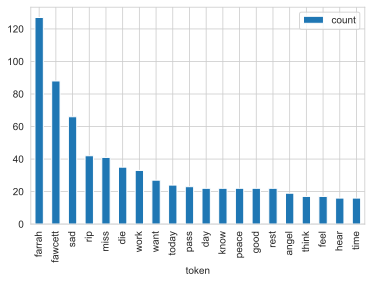

In [46]:
neg_df = df_sm[df_sm['sentiment']==0]
neg_tokens = neg_df.text_nav.map(my_tokenizer).sum()
neg_counter = Counter(neg_tokens)
#neg_counter.most_common(20)
neg_counter = Counter(remove_stopwords(neg_tokens))
neg_freq_df = pd.DataFrame.from_records(neg_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
neg_freq_df.plot(kind='bar', x='token');

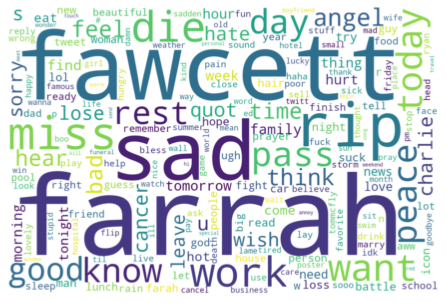

In [47]:
wordcloud(neg_counter)

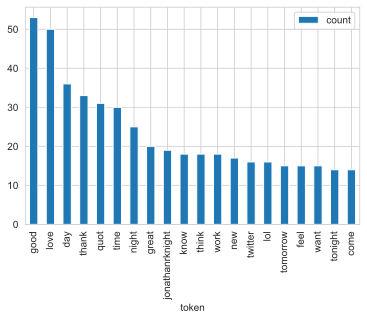

In [48]:
pos_df = df_sm[df_sm['sentiment']==4]
pos_tokens = pos_df.text_nav.map(my_tokenizer).sum()
pos_counter = Counter(pos_tokens)
#pos_counter.most_common(20)
pos_counter = Counter(remove_stopwords(pos_tokens))
pos_freq_df = pd.DataFrame.from_records(pos_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
pos_freq_df.plot(kind='bar', x='token');

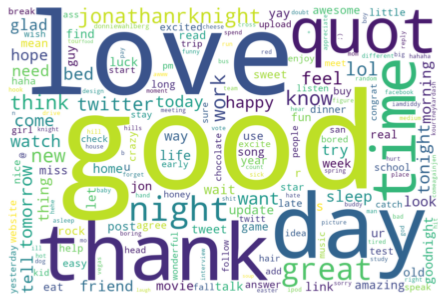

In [49]:
wordcloud(pos_counter)

Well, WOW, those are some mighty positive words, in the positive documents word cloud! 

The most frequently occurring words are clearly different in the text labeled as positive and the text labeled as negative.

In the early phases of development, we were using a dataset, centered around the change at 800,000 rows, with 4000 samples. In this sample, the words "Farrah" and "Fawcett" were the most common words. This suggested perhaps that we need to be more careful about subsampling our data (perhaps a random selection approach would yeild less weird results?) it made for a surprise when we looked at positive and negative sentiment. Who would have thought that "Farrah" and "Fawcett" would be exclusively from statements with negative sentiment? Surprised me, for sure, but there it is. Data Exploration!

## Exploring text complexity

In [50]:
df_sm['no_tokens'] = df_sm.text_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

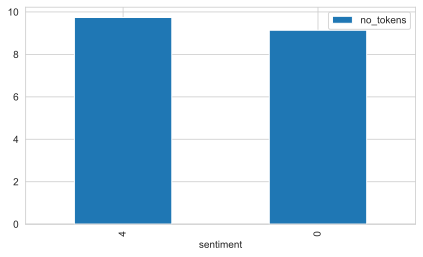

In [51]:
# mean number of tokens by sentiment
df_sm.groupby(['sentiment']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [52]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

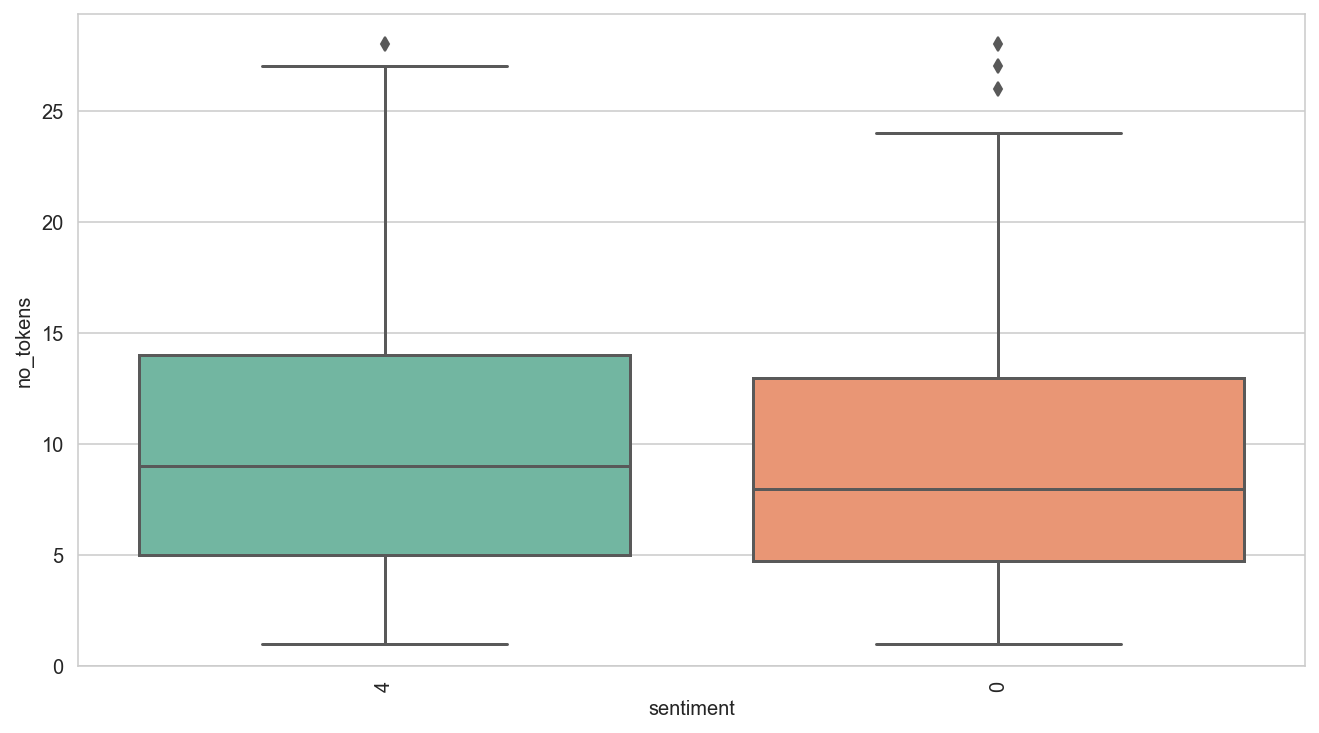

In [53]:
multi_boxplot(df_sm, 'sentiment', 'no_tokens');

In [54]:
# print text of outliers
df_sm['text_lemma'][df_sm.no_tokens > 1500]

Series([], Name: text_lemma, dtype: object)

In [55]:
# cut-off diagram at y=40

# CAREFUL!!! this isn't that meaningful, and it takes for freaking ever to plot, even with only 4000 rows!!!

# multi_boxplot(df_sm, 'username', 'no_tokens', ylim=40)

------------------------------------------

# ===============================
# Feature Engineering
# ===============================

--------------------------------------------

Feature Engineering and Feature Selection are part of the Data Preparation stage of the CRISP-DM methodology. After data has been cleaned and explored, it must be transformed from raw, unstructured text into a structured numeric format that can be used as inputs for our models. Simpler Data Engineering techniques focus on vectorizing individual words, with little emphasis on the contexts of the words. We use Bag of Words and Bag of N-Grams to explore these simpler approaches. While easy to use, and not terribly demanding in terms of computer power required, these techniques are fundamentally less powerful than more modern, processor intensive techniques that concern themselves more with the context of the words. We use pre-trained word embeddings for our advanced feature engineering efforts, in order to avoid computational bottlenecks. If time allows, we may attempt to train our own embedding at some point.

### A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute.

## Bag of Words Model

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df_sm['text_nav'])
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [57]:
# get all unique words in the corpus
vocab_bagowords = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab_bagowords)

,aaaand,aaawwww,aaru,abay,abc,ability,able,academy,access,account,accountant,ace,ache,ack,ackin,...,yoeyfreshier,yoshigi,young,youth,youtube,yr,yrold,yrs,yum,yvonne,zealand,zhen,zone,zta,½re
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Micro dataframe visualization experiment

To satisfy my curiosity, I'm going to make up a teeny weeny little dataframe, to see if I can see some values in one of these arrays as it gets previewed here in the pandas dataframe thing. We just see the corners. All zeroes. Let's see if it looks more satisfying with just a handful of rows...

In [58]:
df_micro = df_sm[1:10]
cv_micro = CountVectorizer(min_df=0., max_df=1.)
cv_micro_matrix = cv_micro.fit_transform(df_micro['text_nav'])
cv_micro_matrix = cv_micro_matrix.toarray()
cv_micro_matrix

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [59]:
# get all unique words in the corpus
vocab_micro = cv_micro.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_micro_matrix, columns=vocab_micro)

,ahahah,ahhhhhhhhhhhhh,annie,annoy,arizona,beautiful,brag,cancer,date,day,die,farrah,fawcett,future,go,...,may,mike,poor,rip,shelbycasanova,suck,teamddemilovato,tizzy,tomorrow,travel,upsetting,wanna,want,wife,wish
0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Oh, that's much more gratifying!

While it's clearly useless from a practical perspective, it's nice to be able to see some numbers that aren't zeroes and let me know that the code is doing the thing I expect the code to be doing. I've got to try this on the next ones, too!

## Bag of N-Grams model

A word is just a single token, often known as a unigram or 1-gram. We already know that the Bag of Words model doesn’t consider order of words. But what if we also wanted to take into account phrases or collection of words which occur in a sequence? N-grams help us achieve that. An N-gram is basically a collection of word tokens from a text document such that these tokens are contiguous and occur in a sequence. Bi-grams indicate n-grams of order 2 (two words), Tri-grams indicate n-grams of order 3 (three words), and so on. The Bag of N-Grams model is hence just an extension of the Bag of Words model so we can also leverage N-gram based features. The following example depicts bi-gram based features in each document feature vector.

In [60]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(df_sm['text_nav'])

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab)

,aaaand portfolio,aaawwww farrah,aaru hithavaru,abay sa,abc news,ability quiet,able busy,able feel,able married,academy family,access research,account create,accountant tomorrow,ace time,ache chair,...,young press,youth work,youtube season,youtube video,yr lastnight,yrold reflection,yrs leav,yum could,yum plan,yvonne daaang,zealand year,zhen thing,zone tweet,zta due,½re fucking
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This gives us feature vectors for our documents, where each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.

### And now with the Micro Dataframe:

In [61]:
bv_micro = CountVectorizer(ngram_range=(2,2))
bv_micro_matrix = bv_micro.fit_transform(df_micro['text_nav'])

bv_micro_matrix = bv_micro_matrix.toarray()
vocab_micro = bv_micro.get_feature_names()
pd.DataFrame(bv_micro_matrix, columns=vocab_micro)

,ahhhhhhhhhhhhh go,annie korea,annoy like,arizona annoy,beautiful rip,brag want,cancer suck,date tizzy,day arizona,farrah fawcett,farrah heartbroken,farrah poor,fawcett cancer,fawcett hear,future brag,...,kill leave,korea tomorrow,like go,may kill,mike farrah,poor beautiful,shelbycasanova wife,suck die,teamddemilovato hahahahaing,tizzy future,tomorrow wanna,travel go,wanna wish,wife hardcore,wish ahhhhhhhhhhhhh
0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0


# TF-IDF Model

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency. There are multiple variants of this model but they all end up giving quite similar results.

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df_sm['text_nav'])
tv_matrix = tv_matrix.toarray()

vocab_tfidf = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,aaaand,aaawwww,aaru,abay,abc,ability,able,academy,access,account,accountant,ace,ache,ack,ackin,...,yoeyfreshier,yoshigi,young,youth,youtube,yr,yrold,yrs,yum,yvonne,zealand,zhen,zone,zta,½re
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00
996,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
997,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
998,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Gotta try that with the Micro Dataframe...

In [63]:
tv_micro = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_micro_matrix = tv_micro.fit_transform(df_micro['text_nav'])
tv_micro_matrix = tv_micro_matrix.toarray()

vocab_micro = tv_micro.get_feature_names()
pd.DataFrame(np.round(tv_micro_matrix, 2), columns=vocab_micro)

,ahahah,ahhhhhhhhhhhhh,annie,annoy,arizona,beautiful,brag,cancer,date,day,die,farrah,fawcett,future,go,...,may,mike,poor,rip,shelbycasanova,suck,teamddemilovato,tizzy,tomorrow,travel,upsetting,wanna,want,wife,wish
0,0.00,0.00,0.00,0.00,0.00,0.54,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.00,...,0.00,0.00,0.54,0.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.30,0.30,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.51,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.30,0.00,0.30,0.00,0.00,0.30
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.35,0.00,0.00,0.00,0.00,0.35,0.00,...,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.35,0.35,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.27,0.35,0.00,0.00,...,0.00,0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.51,0.00,0.00,0.43,0.33,0.43,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.54,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.36,0.36,0.00,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.00,0.30,...,0.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


--------------------------------------

# ===========================
# Feature Selection
# ===========================

--------------------------------------

Feature Selection is an essential step, which allows us to identify which features are most important to the predictive abilities of our models. Filter methods of Feature Selection involve looking at individual features in isolation, giving them a score by which they can be ranked in terms of their usefulness. We use Univariate Chi-squared statistical tests. Wrapper methods of Feature Selection consider sets of features in combination, which can give deeper insights into which features to select given their interactions and correlations with one another. We use Recursive Feature Elimination and Bagged Decision Trees for this type of feature selection. There are also Embedded Feature Selection techniques, however, these are done in concert with the modeling phase of the project, and if they will be attempted, they will be attempted during the modeling phase of the project.

## Filter Method

### The scikit-learn library provides the SelectKBest class that uses the chi squared (chi^2) statistical test to select the best features

Our Bag of Words vectorization has provided us with over a thousand features. SelectKBest can identify which of these features are most strongly correlated with our sentiment label. We produce a new Bag of Words containing only the features SelectKBest determines are most important.

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# select the 50 features that have the strongest correlation to a class from the
# original thousands of features
selector = SelectKBest(chi2, k=500)
selected_features = \
bow_selected = selector.fit(cv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features

array([  20,   21,   27,   30,   31,   34,   50,   53,   59,   70,   73,   81,
         83,   91,  103,  112,  119,  127,  135,  136,  137,  141,  146,  153,
        173,  174,  178,  180,  182,  186,  188,  193,  204,  209,  221,  223,
        226,  242,  246,  247,  250,  262,  263,  267,  269,  270,  271,  272,
        290,  298,  300,  305,  322,  324,  334,  335,  340,  349,  365,  369,
        375,  379,  391,  398,  408,  415,  418,  419,  420,  424,  429,  432,
        433,  448,  456,  464,  472,  473,  479,  482,  483,  485,  492,  494,
        496,  503,  510,  517,  537,  544,  548,  556,  563,  571,  575,  576,
        577,  579,  588,  600,  605,  606,  610,  616,  618,  620,  627,  628,
        632,  638,  646,  649,  650,  653,  682,  709,  710,  711,  727,  733,
        734,  738,  744,  745,  753,  754,  755,  758,  760,  768,  771,  776,
        780,  787,  797,  809,  823,  828,  829,  844,  866,  880,  881,  887,
        895,  896,  898,  914,  919,  921,  922,  92

## Interpreting the Selected Features

That array of numbers tells us which indecies of the Bag of Words vectorization were deemed most important by SelectKBest. Kind of boring on its own. It would be much more gratifying to see the actual words it has decided are most important.

## View list of words selected by SelectKBest

In [65]:
for x in selected_features:
    print(vocab_bagowords[x], end=' ')

add addict afraid age agree ahhh alexa allan amazing angel animal annoy answer appreciate artistic asleep attack austin awesome awful aww awwww baby bad battle bb be beat beautiful bed beer believe beyonce bike bless blessing blog boo boom border boring boy boyfriend brand brave brazil break breakfast brother buddy buffy bummed buy bye cancel cancer car carry challenge charlie check cheese chocolate chubbx class client close clothe club coffee college come comeagainjen congrat cookie core count country crack crap crappy crazy cross cruise cry cure cvs dad day ddlovato death dentist design di die diego different dinner discover dog donnie donniewahlberg double drag draw dread drink drinking drunk dun early easter easy ed entire excellent excite excited face faith fall family farah farrah favorite fawcett fawcetts fb feather felt fight final finish first flip food freakin friday friend funeral gettin give glad gmail good goodbye goodnight great grfl gross grow guess hahaha half hang happ

## Wrapper Method

### Recursive Feature Elimination

The Recursive Feature Elimination (or RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [66]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [78]:
model = LogisticRegression(solver='lbfgs', max_iter=10)
rfe = RFE(model, 500)
fit = rfe.fit(cv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 500
Selected Features: [False False False ... False False False]
Feature Ranking: [ 140 2110 1109 ... 1092  461  955]


In [81]:
i=0
for x in fit.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

add addict afford afraid agree ahhhh album alex allan amazing angel annoy argue artistic ask asleep ass assignment attack attractive awake awesome awful awww baby bad bb be beat bed begin berianreed big bike blackberrys bog bonjour boo boom border bored boring bothwell bowls boy boyfriend brand breakfast brettjohn bridge broadway brother brussels buddy bunny butt buy bye ca cable cancel cancer candid car carry celery centrelink challenge chat check cheer cheers cheese chill chilling chocolate chubbx citizen class clean cliff close clothe cobra coffee college comeagainjen computer confuse congrat cookie cool core could crack crap crappy cross cry cut cvs cw cybercommand dad dam damn danielc darn davesjessica ddi ddlovato dearbhlaoconnor deck design dfizzy di die different dinner discourse djincredible do dog donnie donniewahlberg dread drink dump dun dundrum dunno early earth easter easy email employe empty endless entire erin exam example excite excited face fact faith fan farrah fat f

## More Wrapper Methods

## Bagged Decision Trees - ExtraTreesClassifier classifier class

In [68]:
from sklearn.ensemble import ExtraTreesClassifier

In [69]:
# feature extraction
model_bagged = ExtraTreesClassifier(n_estimators=10)
model_bagged.fit(cv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged.feature_importances_)
# np.set_printoptions(threshold=200)

[0.00e+00 1.33e-05 0.00e+00 4.76e-06 0.00e+00 3.03e-04 1.28e-03 1.33e-05
 4.21e-06 2.19e-07 3.02e-06 0.00e+00 0.00e+00 0.00e+00 7.99e-07 0.00e+00
 0.00e+00 0.00e+00 2.88e-04 7.35e-06 1.08e-03 1.27e-03 0.00e+00 1.38e-06
 1.29e-06 0.00e+00 2.57e-04 8.10e-04 3.64e-06 5.71e-04 0.00e+00 8.41e-04
 1.41e-04 0.00e+00 0.00e+00 1.91e-03 2.00e-05 1.40e-04 0.00e+00 0.00e+00
 0.00e+00 2.50e-06 0.00e+00 0.00e+00 1.06e-06 0.00e+00 0.00e+00 3.80e-04
 0.00e+00 2.89e-03 0.00e+00 0.00e+00 1.33e-05 2.00e-04 0.00e+00 7.22e-05
 4.44e-06 4.98e-06 0.00e+00 3.58e-04 0.00e+00 1.05e-05 6.53e-04 3.33e-05
 3.00e-04 4.79e-04 0.00e+00 5.56e-06 0.00e+00 2.04e-04 4.16e-03 0.00e+00
 2.00e-05 8.79e-06 1.05e-04 1.21e-05 0.00e+00 0.00e+00 1.78e-05 3.05e-05
 3.33e-05 4.36e-04 2.84e-07 8.41e-04 4.88e-04 6.62e-04 0.00e+00 3.27e-04
 0.00e+00 0.00e+00 5.43e-07 0.00e+00 3.81e-04 1.47e-06 0.00e+00 2.38e-04
 0.00e+00 0.00e+00 6.83e-04 2.91e-04 1.10e-05 0.00e+00 8.08e-07 2.00e-05
 2.26e-06 0.00e+00 7.70e-04 3.33e-05 2.31e-04 0.00e

 0.00e+00 0.00e+00 0.00e+00 2.44e-04 5.63e-06]


## Feature Selection on TF-IDF encoded features

### Wrapper Method - SelectKBest

In [83]:
selector_tfidf = SelectKBest(chi2, k=500)
selected_features_tfidf = \
selector_tfidf.fit(tv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_tfidf

array([  16,   20,   21, ..., 2626, 2629, 2632], dtype=int64)

In [85]:
for x in selected_features_tfidf:
    print(vocab_tfidf[x], end=' ')

actress add addict afraid age agree ahhh ahhhh alex amandahesser amazing ang angel anne annoy answer aparajuli appreciate aroundd artistic ashh asleep asscancer attack austin awesome awful aww awww awwww baby bad bah battle bb be beat beautiful bed beer believe berianreed bike blackberrys bless blessing blog blush boo boom border bored boring boy boyfriend brand brave brazil breakfast brettjohn brother buddy bummed buy bye cancel cancer car carry challenge charlie cheer cheese chocolate chubbx class clothe club coffee comeagainjen confuse congrat cookie core could count country craigsutton crap crappy croconaw cross cruise cry cupcakes cure cvs cyndalboo dad dam davesjessica davidgideon ddlovato death debby denise dentist design dfizzy di die diego different dnt dog dollar donnie donniewahlberg dramabeat draw dread drink drinking drunk eagene early easter easy ed effect elissakim entire excellent excite excited faith family fancydee farah farrah faucett favorite fawcett fawcetts fb fea

In [86]:
model_tfidf = LogisticRegression(solver='lbfgs', max_iter=10)
rfe = RFE(model_tfidf, 500)
fit_tfidf = rfe.fit(tv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 500
Selected Features: [False False False ... False False False]
Feature Ranking: [ 140 2110 1109 ... 1092  461  955]


In [87]:
i=0
for x in fit_tfidf.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

add addict afraid age agree ahhhh alex amazing amyg ang angel annoy answer appreciate aroundd artistic ask asleep attack awake awesome awful aww awww baby bad bah battle bb be beat bed berianreed big bike blackberrys blessing blew blue blush bog boo boom border bored boring boy boyfriend brand break breakfast brettjohn brother brussels bubba buddy butterfly buy bye ca cancel cancer car carry cat cel centrelink challenge change charlie check cheer cheese chill chippewa chocolate chubbx class close clothe coffee college comeagainjen confuse congrat cookie cool core could crack crap crappy cross cry cupcakes cut cvs cw dad dam damn davesjessica day daylol ddlovato death dentist design dfizzy die diego different dinner dnt dog dollar donnie donniewahlberg dread drink drinking drive drunk dun dundrum early easter easy eat effect english entire ento excite excited face facebook faith family fan farah farrah favorite fawcett feel felt fight finish finished first follow follower food forgot fr

# Selecting TF-IDF Features with Bagged Decision Trees

### This represents our most sophisticated feature selection method, being used with our most sophisticated feature engineering method.

Earlier, in the Feature Engineering section, we vectorized our text data using the Term Frequency - Inverse Document Frequency method. This resulted in our documents being represented as vectors with thousands of dimensions. Here we will select the most statistically relevant dimensions using a Wrapper Method known as an Extra Trees Classifier, which is an example of Bagged Decision Trees. 

In [71]:
model_bagged_tfidf = ExtraTreesClassifier(n_estimators=20)
model_bagged_tfidf.fit(tv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_tfidf.feature_importances_)
# np.set_printoptions(threshold=200)

[2.09e-04 2.25e-06 0.00e+00 0.00e+00 5.90e-06 3.80e-04 5.82e-04 1.65e-04
 0.00e+00 1.37e-07 0.00e+00 0.00e+00 1.22e-06 1.46e-04 1.67e-06 5.19e-06
 8.94e-05 4.73e-04 1.08e-04 0.00e+00 1.31e-03 6.36e-04 7.62e-06 2.76e-07
 1.02e-06 6.75e-07 1.50e-04 6.30e-04 2.22e-06 0.00e+00 7.37e-05 3.35e-04
 6.07e-05 1.95e-04 2.64e-04 1.45e-03 2.05e-04 4.06e-04 1.16e-04 1.33e-04
 1.38e-04 0.00e+00 3.33e-07 4.09e-07 5.29e-07 7.27e-07 0.00e+00 6.34e-05
 0.00e+00 2.98e-03 0.00e+00 0.00e+00 1.94e-05 1.29e-04 9.14e-05 1.23e-04
 0.00e+00 1.52e-06 1.67e-05 1.46e-03 0.00e+00 0.00e+00 7.45e-05 1.38e-05
 2.71e-04 1.62e-04 7.32e-06 2.22e-06 0.00e+00 6.32e-04 5.27e-03 0.00e+00
 0.00e+00 1.07e-04 0.00e+00 0.00e+00 1.78e-04 8.33e-07 4.33e-07 3.06e-04
 0.00e+00 6.00e-04 6.44e-05 3.49e-04 5.27e-04 7.04e-04 1.43e-05 1.67e-05
 2.65e-07 1.87e-04 1.98e-07 3.08e-07 6.02e-04 0.00e+00 2.46e-04 2.23e-04
 1.83e-04 0.00e+00 5.64e-04 5.09e-04 0.00e+00 3.12e-06 0.00e+00 1.86e-04
 1.20e-06 0.00e+00 3.82e-04 0.00e+00 1.82e-04 1.14e

 0.00e+00 0.00e+00 1.34e-04 2.04e-04 3.91e-05]


In [72]:
print(model_bagged_tfidf.n_classes_)
print(model_bagged_tfidf.estimators_)

2
[ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, random_state=757848699,
                    splitter='random'), ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, random_state=1115362938,
                    splitter='random'), ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_s

# Milestone 1 - Conclusion

### Data has been loaded, cleaned, and explored.

### Feature Engineering has been carried out using Bag of Words, Bag of N-Grams, and TF-IDF (Term Frequency - Inverse Document Frequency)

### Three Feature Selection methods, Select K Best, Recursive Feature Elimination, and Bagged Decision Trees, have been carried out on the engineered features.

### A sample of cleaned data has been saved to a file, for use in an "Advanced" part of this project using Tensorflow and ELMo in The Cloud.

Dec 14 2019

---------------------

-----------------------

-----------------------

----------------------

----------------------

---------------------
#
#
#
### End of working working file.
#
#
#

## Sentiment Analysis with Afinn

As a quick and dirty sanity check, I've set up Afinn in the early stages of data cleaning, and intend to keep a little record of Afinn's performance, as I increase the rigour of the data cleaning.

In [73]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [74]:
texts = np.array(df_sm['text_nav'])
sentiments = np.array(df_sm['sentiment'])

# extract data for model evaluation
#train_texts = texts[:10000]
#train_sentiments = sentiments[:10000]

#test_texts = texts[40000:60000]
#test_sentiments = sentiments[40000:60000]
sample_ids = [626, 533, 310, 123, 654, 400]

In [75]:
for text_clean, sentiment in zip(texts[sample_ids], sentiments[sample_ids]):
    print('TEXT:', texts)
    print('Actual Sentiment:', sentiment)
    print('Predicted Sentiment polarity:', afn.score(texts))
    print('-'*60)

TEXT: ['kristacolvin cd car song head right' 'farrah poor beautiful rip'
 'annie korea tomorrow wanna wish ahhhhhhhhhhhhh go travel go ahahah' ...
 'thastevieg bunnys name lucy lmao go guess name'
 'pixelpipe iphone os miss guy update' 'denise love']
Actual Sentiment: 4


TypeError: cannot use a string pattern on a bytes-like object

In [ ]:
# Predict sentiment with Afinn

sentiment_polarity = [afn.score(Text) for Text in normalized_texts]
#predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]
predicted_sentiments = [4 if score >= 1.0 else 0 for score in sentiment_polarity]

In [ ]:
#meu.display_model_performance_metrics(true_labels=test_texts, predicted_labels=predicted_sentiments, 
#                                  classes=['positive', 'negative'])
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
                                  classes=[4, 0])

## Checking cleaning with Afinn

I'm curious about how deeper cleaning affects predicitive models. So I set up Afinn after the very first round of data cleaning, and am going to track results here in the markdown. For simplicity, I will monitor the effects of different levels of cleaning on "weighted avg f1-score"

Round 1, most basic cleaning, 20000 rows:  0.63

Round 2, include normalization, 20000 rows: 0.63

In [ ]:
df_sm.head()

## Save to database

In [ ]:
df.to_sql('df_sm', con)